## POOL PERL_WETH
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
EXPERIMENT_ID = 73

X_NAME = 'PERL'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [4]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [5]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [6]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [7]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [8]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,PERL,1.000000,0.0,0.000000,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2020-08-20 07:31:20,2020-08-20 07:31:20,0x259920fbd70f1fb6081890bc61f3d04bb65f7fdb71be...,0x21e479e62603a3ea0b6dc687cb86b9938d39a3dd,0x21e479e62603a3ea0b6dc687cb86b9938d39a3dd,0,0.000000,0.000000,0.000000,0,0,False,0.000000,0.000000,0.000000,0,0,False,NaN,NaN
1,2,WETH,PERL,0.330000,0.0,344.539489,0.001320,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,1.0,2020-08-20 07:31:35,2020-08-20 07:31:33,0xa2579b1d7d65a6196165219ce988979ed0c07a0ed4cb...,0x90b98c3db94f6d2a088a3d7e4c86e15a39f8ee0d,0x90b98c3db94f6d2a088a3d7e4c86e15a39f8ee0d,2,450.000000,0.100000,45.000000,0,0,False,105.460511,0.428680,45.208812,0,0,False,0.004065,17.291776
2,3,WETH,PERL,0.100000,0.0,19.785837,0.000400,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,12.0,2020-08-20 07:34:20,2020-08-20 07:34:18,0x394e02caf2236dabe102ee16f563e438cc6dc4fa8c44...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x21f1d0daa58f49a0a03855966e79026d2001d00e,3,105.460511,0.428680,45.208812,0,0,False,85.674674,0.528280,45.260217,0,40592,False,0.006166,0.516940
3,4,WETH,PERL,0.111533,0.0,14.811370,0.000446,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,27.0,2020-08-20 07:38:05,2020-08-20 07:37:55,0xa7b8b130b5441fbf6aa77fe37c893ec9d9c76ae375e6...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc26da32095985cd03201103bf400fc8058621240,4,85.674674,0.528280,45.260217,0,40592,False,70.863304,0.639367,45.307638,2,77081,False,0.009023,0.463245
4,5,PERL,WETH,2.058032,0.0,0.017869,0.000071,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,41.0,2020-08-20 07:41:35,2020-08-20 07:41:29,0xb69d1b70c6d0059ff0ec29acf0dc39756dd5c38c90f2...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,5,70.863304,0.639367,45.307638,2,77081,False,72.921336,0.621426,45.315217,3,100356,False,0.008522,-0.055491


In [9]:
swaps0_df.status.value_counts()

SUCCESS                1532
NOT_ENOUGH_RESERVES       1
Name: status, dtype: int64

In [10]:
swaps1_df.status.value_counts()

SUCCESS                1532
NOT_ENOUGH_RESERVES       1
Name: status, dtype: int64

In [11]:
swaps1_df[swaps1_df.status != 'SUCCESS']

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,0,WETH,PERL,1.0,0.0,0.0,NaN,NOT_REACHED,NaN,NaN,NaN,NaN,NOT_ENOUGH_RESERVES,0.0,2020-08-20 07:31:20,2020-08-20 07:31:20,0x259920fbd70f1fb6081890bc61f3d04bb65f7fdb71be...,0x21e479e62603a3ea0b6dc687cb86b9938d39a3dd,0x21e479e62603a3ea0b6dc687cb86b9938d39a3dd,0,0.0,0.0,0.0,0,0,True,0.0,0.0,0.0,0,0,True,NaN,NaN


In [12]:
mints1_df.head()

,id,X_amount,Y_amount,timestamp,status,block_number,block_timestamp,transaction_timestamp,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on
0,1,450.000000,0.100000,1597908680,SUCCESS,0,1597908680,1597908680,1,0.000000,0.000000,0.000000,0,0,True,450.000000,0.100000,45.000000,0,0,True
1,19,2819.900000,0.184215,1601400384,SUCCESS,232781,1601400395,1601400384,19,842.424416,0.053505,45.073522,522,20931784798,True,3662.324416,0.237720,870.606907,522,20931784798,True
2,66,63.500000,0.002946,1604684924,SUCCESS,451750,1604684930,1604684924,66,1048.829712,0.047281,49.589663,697,87721956260,True,1112.329712,0.050227,55.868599,697,87721956260,True
3,70,13664.843820,0.458411,1605410933,SUCCESS,500151,1605410945,1605410933,70,552.970758,0.101745,56.262279,730,112800194019,True,14217.814578,0.560157,7964.206768,730,112800194019,True
4,128,51345.001842,4.000000,1615997610,SUCCESS,1205929,1615997615,1615997610,128,1313.953565,0.071517,93.969747,1085,2197561250547,True,52658.955407,4.071517,214401.821299,1085,2197561250547,True


The swap transaction which was blocked because of not enough reserves in the pool is the first processed transaction by the AMM. The reason for it is that both this transaction and the first mint happened inside the same block (therefore the transaction timestamps are the same), but uniswap subgraph doesn't provide additional information regarding the execution order of transaction, so it's taken aleatory.

In [13]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.0


In [14]:
swaps1_df.mitigator_check_status.value_counts()

CANT_CONSULT_ORACLE    1256
CHECKED                 276
NOT_REACHED               1
Name: mitigator_check_status, dtype: int64

In [15]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.8193085453359426


In [16]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    4
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    4
Name: status, dtype: int64


No transactions have been **blocked by the volatility mitigation mechanism**. In about **81.9%** of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

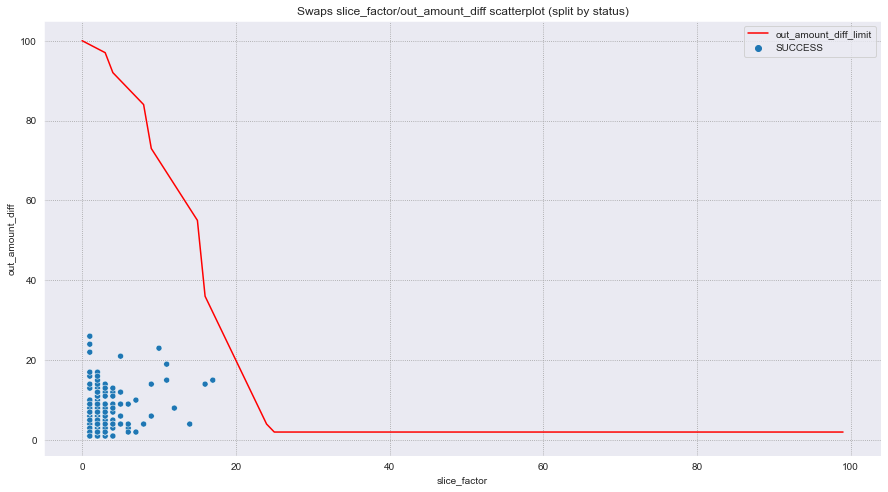

In [17]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

The majority of the swaps are not present in the above plot, as for them TWAP coudn't be computed because of the missing observations inside the DSW oracle, and therefore the out_amount_diff is missing

Text(0, 0.5, 'Count')

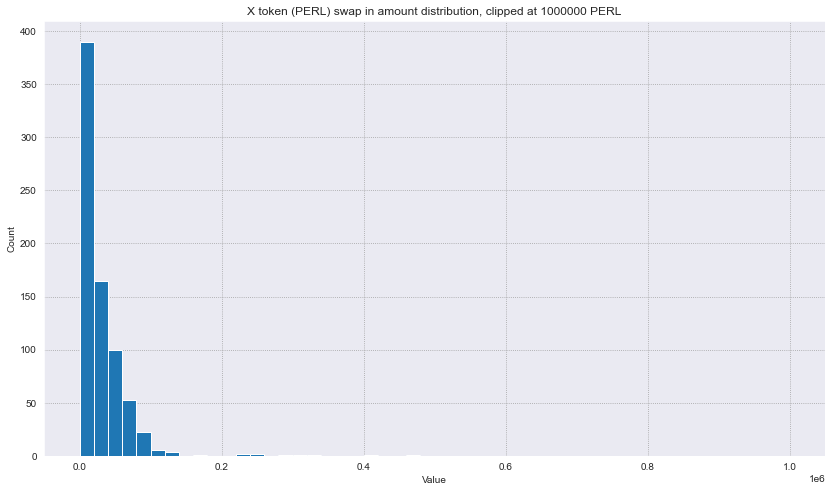

In [18]:
UPPER_LIMIT = 1000000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

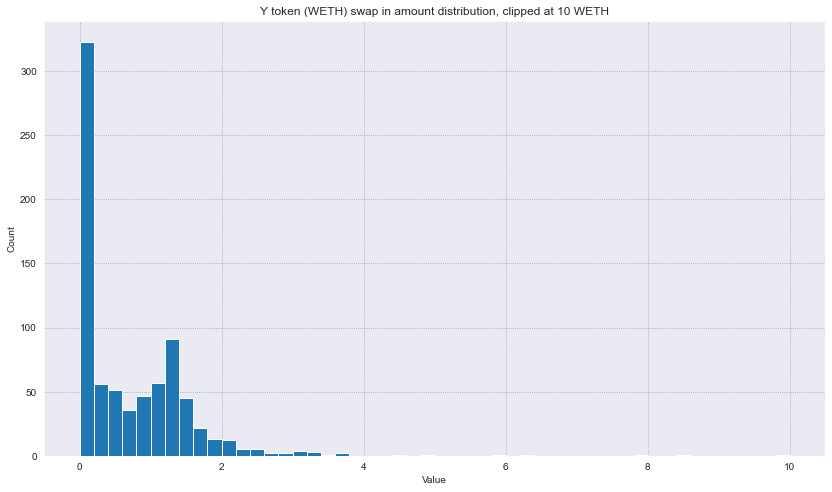

In [19]:
UPPER_LIMIT = 10

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

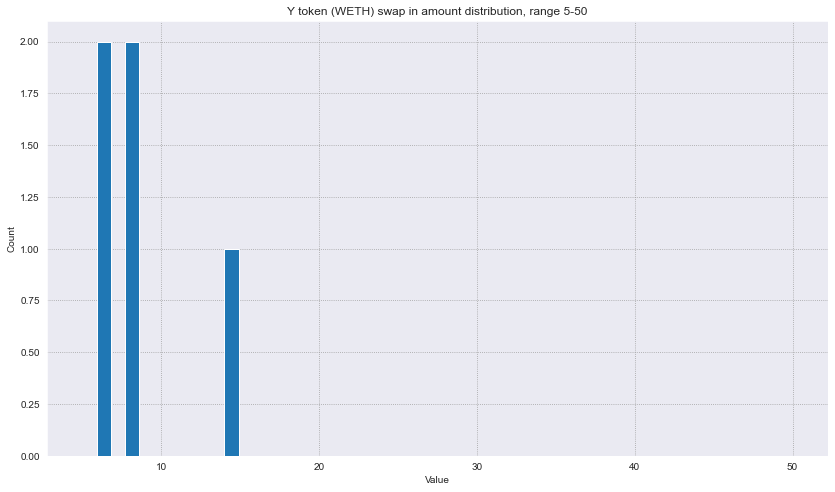

In [26]:
LOWER_LIMIT = 5
UPPER_LIMIT = 50
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

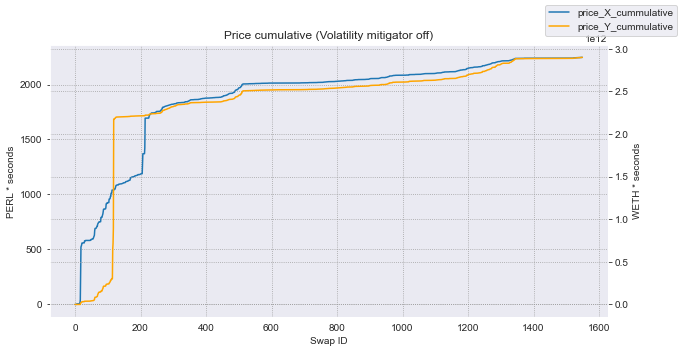

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

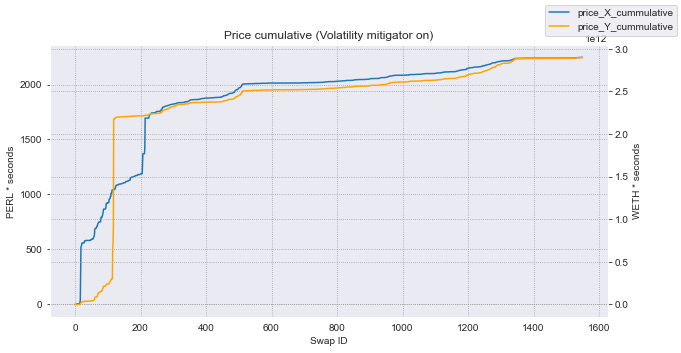

In [28]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

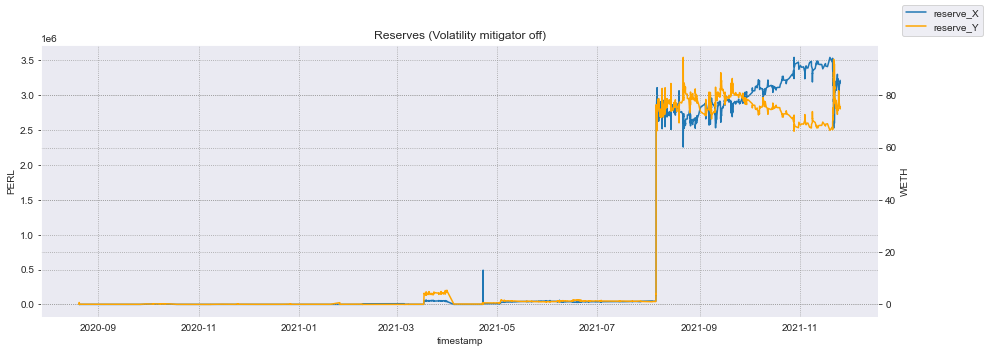

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

There is a slight increase in the reserves during 2021.03 - 2021.05 period. Also, the reserves did increase significantly about 2021.08, when a lot of mints were provided

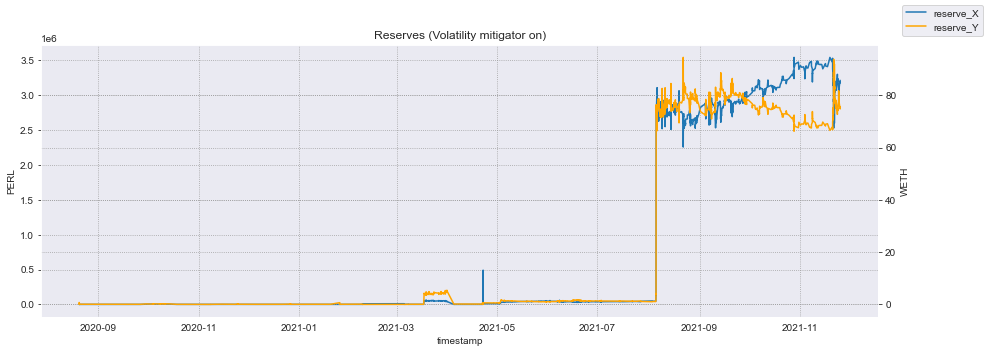

In [64]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is similar with volatility mitigation mechanism enabled/disabled**

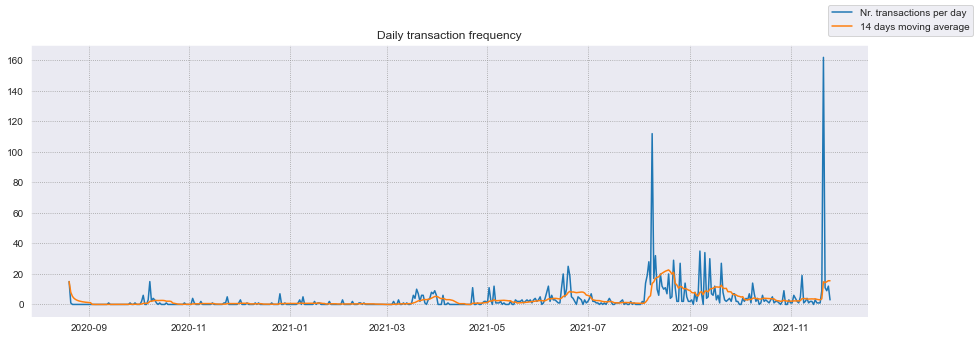

In [117]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled24 = sim1_indexed_df.resample('24h').size()
mov_avg = resampled24.rolling('14d').mean()

fig, ax = plt.subplots(figsize=(15, 5))

plt.plot_date(resampled.index, resampled.values, markersize=1, linestyle='solid', marker='None', label='Nr. transactions per day')
plt.plot_date(mov_avg.index, mov_avg.values, markersize=1, linestyle='solid', marker='None', label='14 days moving average')

ax.set_title('Daily transaction frequency')
fig.legend()

It can be observed that the transaction frequency increased after tha large swaps in 2021.08, but the increase was not that significant and it kept decreasing since then

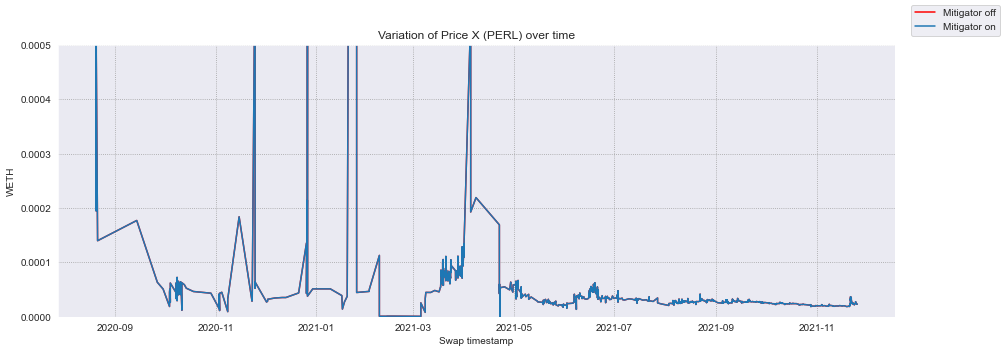

In [119]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 0.0005)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**The price variation is being decreased significantly since May 2021, during the small increase of the reserves**

## Count number of 1 hour periods with no swaps

Below, the distribution of the number of swaps per hour, for 3 stages of the same duration of the pool is computed 

- 1st stage - initial period 
- 2nd stage - middle period
- 3nd stage - last period

In [67]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled = sim1_indexed_df.resample('1h').size()
resampled

transaction_timestamp
2020-08-20 07:00:00    11
2020-08-20 08:00:00     2
2020-08-20 09:00:00     2
2020-08-20 10:00:00     0
2020-08-20 11:00:00     0
                       ..
2021-11-25 04:00:00     0
2021-11-25 05:00:00     2
2021-11-25 06:00:00     0
2021-11-25 07:00:00     0
2021-11-25 08:00:00     1
Freq: H, Length: 11090, dtype: int64

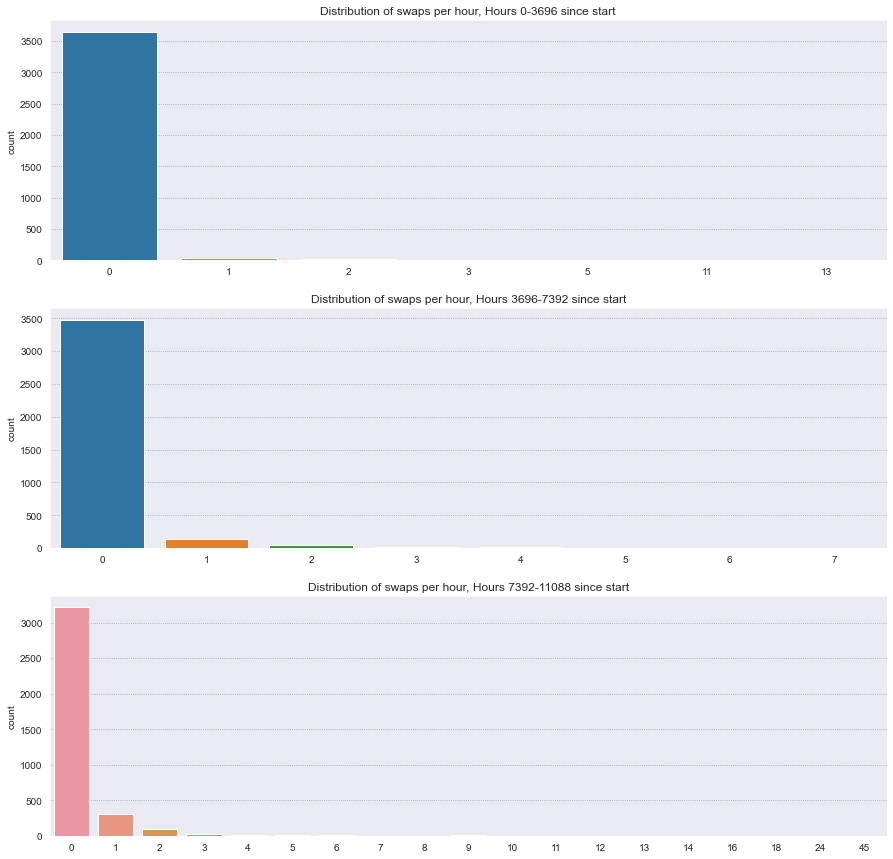

In [68]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
   # time_elapsed = (resampled.index[end_idx] - resampled.index[start_idx])
    
    sns.countplot(x=resampled.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per hour, Hours {start_idx}-{end_idx} since start")
   # ax.set_title('Swaps per hour distribution')

The count for x = 0 (no swaps per hour), shows how many missing periods for TWAP value exist.

For all of this stages in pool development this number exceeds 3000, represending much more than 50% of all 1-hour slots.

## Count number of 48 hour periods with no swaps

In [30]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled24 = sim1_indexed_df.resample('48h').size()
resampled24.head()

transaction_timestamp
2020-08-20    16
2020-08-22     0
2020-08-24     0
2020-08-26     0
2020-08-28     0
Freq: 48H, dtype: int64

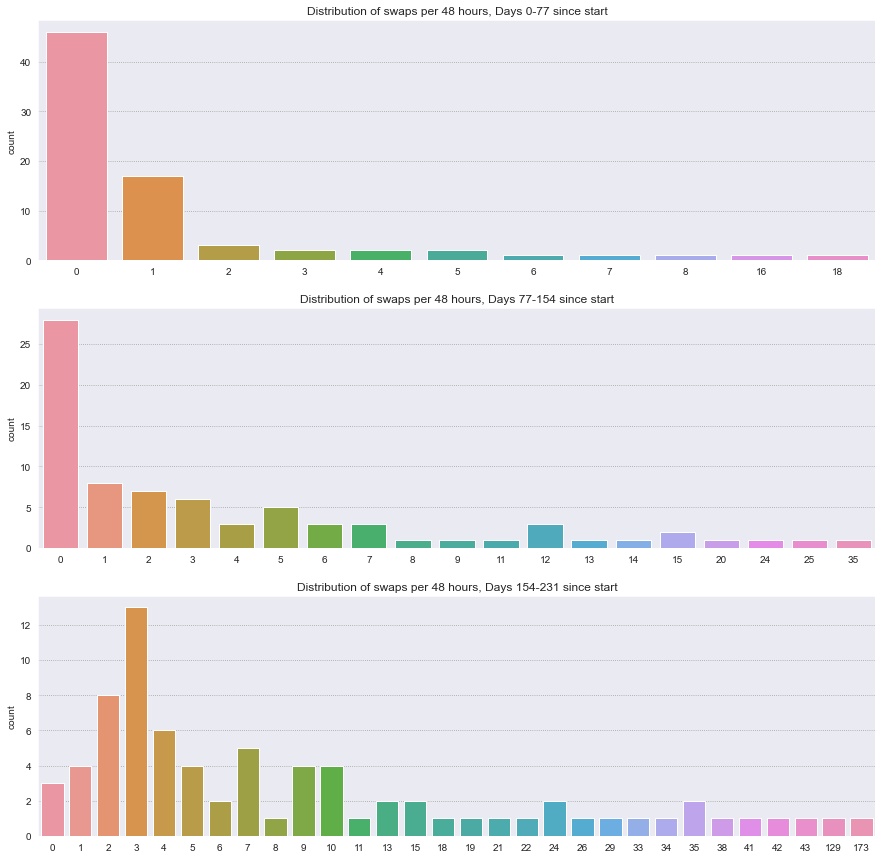

In [122]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled24)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
    
    sns.countplot(x=resampled24.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per 48 hours, Days {start_idx}-{end_idx} since start")
   # ax.set_title('Swaps per hour distribution')

It can be seen that the number of 48 hour periods with no swaps happening decreases in the second and third stage of pool development. During the first stage, only in 3 48-hours periods no swaps were happening

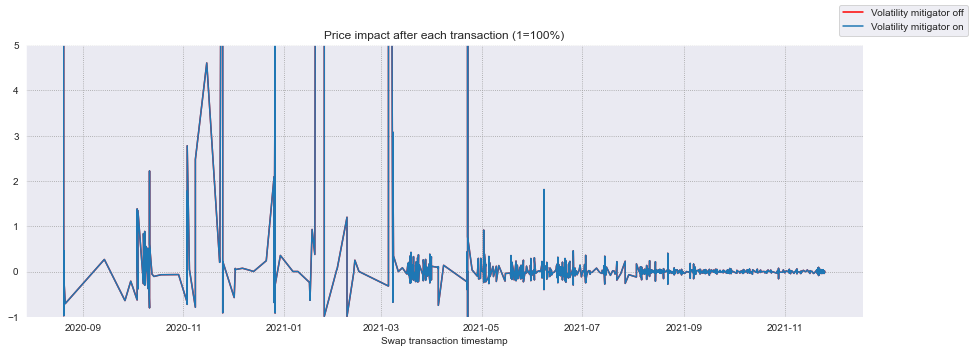

In [123]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 5)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

In the first half of the plot there are a lot of transactions with a high price impact. Most of them
were not blocked by the volatility mitigation mechanism because of the missing observations
inside the oracle. As the liquidity increased, the price became much more stable and the
transaction frequency also increased.


In [33]:
swaps1_df[swaps1_df.price_diff > 0.5]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
1,2,WETH,PERL,0.330000,0.0,344.539489,0.001320,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1.0,2020-08-20 07:31:35,2020-08-20 07:31:33,0xa2579b1d7d65a6196165219ce988979ed0c07a0ed4cb...,0x90b98c3db94f6d2a088a3d7e4c86e15a39f8ee0d,0x90b98c3db94f6d2a088a3d7e4c86e15a39f8ee0d,2,450.000000,0.100000,45.000000,0,0,True,105.460511,0.428680,45.208812,0,0,True,0.004065,17.291776
2,3,WETH,PERL,0.100000,0.0,19.785837,0.000400,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,12.0,2020-08-20 07:34:20,2020-08-20 07:34:18,0x394e02caf2236dabe102ee16f563e438cc6dc4fa8c44...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x21f1d0daa58f49a0a03855966e79026d2001d00e,3,105.460511,0.428680,45.208812,0,0,True,85.674674,0.528280,45.260217,0,40592,True,0.006166,0.516940
20,22,WETH,PERL,0.070378,0.0,2384.907442,0.000282,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,256743.0,2020-10-03 21:17:05,2020-10-03 21:17:02,0x622d6edb69537316f1fababf16bb4e6bb04b3a18d171...,0x66f35c9adf56f148cac033db9bf8e641ff93888a,0x66f35c9adf56f148cac033db9bf8e641ff93888a,22,6785.485369,0.128561,872.350451,558,32190542092,True,4400.577926,0.198658,874.208673,558,32190542092,True,0.000045,1.382684
23,25,WETH,PERL,0.064811,0.0,1431.140014,0.000259,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,259450.0,2020-10-04 08:33:50,2020-10-04 08:33:40,0xde587bd945179269b5d56c76fd011edea35a08deea47...,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,25,5191.911531,0.168608,875.396146,560,33022867638,True,3760.771517,0.233159,876.858578,560,33022867638,True,0.000062,0.909086
26,28,WETH,PERL,0.081636,0.0,1995.396330,0.000327,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,259467.0,2020-10-04 08:38:05,2020-10-04 08:38:00,0x848350d8114b6c2849d8b676ae46a3b332aec1b6c4ae...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7ee8ab2a8d890c000acc87bf6e22e2ad383e23ce,28,5760.771517,0.152509,878.568748,560,33028957635,True,3765.375187,0.233818,880.413085,560,33028957635,True,0.000062,1.345608
29,31,WETH,PERL,0.061683,0.0,1338.227173,0.000247,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,278822.0,2020-10-07 17:16:50,2020-10-07 17:16:44,0x0015ee062b1990299fb64ad2a9c821a003dfc829ec1b...,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,31,5115.575187,0.172368,881.761934,578,37706599840,True,3777.348014,0.233804,883.159920,578,37707045013,True,0.000062,0.836974
33,35,WETH,PERL,0.052952,0.0,1185.123084,0.000212,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,283148.0,2020-10-08 11:18:20,2020-10-08 11:18:15,0xfcb42a69e84ac83878c893635c11caf0887fb793d885...,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,35,5103.420985,0.173321,884.530457,582,38767464352,True,3918.297901,0.226061,885.775347,582,38768347699,True,0.000058,0.698786
36,38,WETH,PERL,0.062224,0.0,1453.025343,0.000249,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,283182.0,2020-10-08 11:26:50,2020-10-08 11:26:37,0x8e7be9bcb8e587efee498aa20c7ff0539bff4d393da3...,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,38,5358.297901,0.165567,887.155736,582,38779250225,True,3905.272557,0.227542,888.613752,582,38779250225,True,0.000058,0.885663
38,40,WETH,PERL,0.057074,0.0,1002.668082,0.000228,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,283216.0,2020-10-08 11:35:20,2020-10-08 11:35:07,0x89a780a229b93d2286326bb398ae925ce4f5cc13b402...,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85,40,4505.272557,0.197381,889.257401,582,38783

For all of the transactions with a price impact greater than 0.5 there were no observations inside the oracle in order to compute the TWAP.

**! See how the changes influence the results in notebooks with suffix _mod1 and _mod2**